<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive only when ls test fails


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/orderml

/content/drive/My Drive/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder. ("ls test")


In [0]:
ls

orderparameter.py  orderparams.ipynb  problems.txt


In [0]:
f = open('problems.txt', 'r')
print(f.read())
f.close()

perpetual problems have no perceived solutions


Install non-default packages here.

In [0]:
!pip install bumps

     |████████████████████████████████| 522kB 4.8MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=2e0afd46b31fcd8a594eb7fc2cd0b283d9ede23bb69ee6eb0cd38e3237fd63a3
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps


"Compile" code.

In [0]:
import sys
import numpy as N
import pylab
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters

 
def bsol(temp,p):
    Tn,Jt,Nf,Bk=p
    t=4.0*(Jt/(Jt+1.0))*Tn/temp
    #print t
    if (Tn<=0) or (Jt<=0) or temp>=Tn:
        xout=0.0
    else:
        xout=optimize.brentq(bfun,0.0,t,args=(temp,p),xtol=1e-6)
 
    return xout
 
def bfun(x,T,p):
    Tn,Jt,Nf,Bk=p
    if x==0.0:
        B=-1.0 # so that it wont find solution at zero
    else:
        B=(x-3*brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
    return B
 
def brill(j,x):
    temp=(2*j+1.0)/2/j
    if x==0:
        Br=0.0
    else:
        Br=temp/N.tanh(temp*x)-1.0/N.tanh(x/2/j)/2/j
    return Br
 
def Intensity(T,p):
    Tn,Jt,Nf,Bk=p
    br=brill(Jt,bsol(T,p))
    bout=Bk+Nf*br**2
    return bout

def orderparameter(T, Tn, Jt, Nf, Bk):
    p=[Tn, Jt, Nf, Bk]
    I=[]
    for t in T:
        I.append(Intensity(t,p))
    return N.array(I)

def fit(model):
    problem = FitProblem(model)
    result = fitters.fit(problem, method='lm')
    for p, v in zip(problem._parameters, result.dx):
        p.dx = v
    return result.x, result.dx, problem.chisq(), problem._parameters

Execute main class.

[243.]
[Parameter(Tn)]


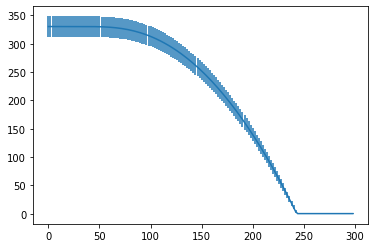

In [42]:
if __name__=='__main__':
 
    #p=[50.0,0.5,100.0,0.0]
    p=[243,.885,330,.3 ]
    #p = [300, .786, 150, .9]
    T=N.arange(0.0001,300.0,2)
    #T=N.arange(10,300,2)
    I=[]
    error = []

    I=orderparameter(T, p[0],p[1],p[2],p[3])
    error= N.sqrt(I)
    #print(error)
    
    M = Curve(orderparameter, T, I, error, Jt = p[1], Nf = p[2], Bk = p[3])
    M.Tn.range(10,600)

    x, dx, chisq, params = fit(M)
    print(x)
    print(params)

    pylab.errorbar(T, I, error)
    pylab.show()